# Clustering

## Packages

In [15]:
from pathlib import Path
import numpy as np
import pandas as pd
import datetime

import scipy.stats as stats
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
import seaborn as sns

## Directory  creation and file management

In [16]:
# creating Path object for current working directory
cwd = Path('./')
root = cwd.resolve().parent
# creating Path object for additional data directory
additional_data_dir = root / 'additional_data'
# create new directory for additional data
Path(additional_data_dir).mkdir(exist_ok=True)

# creating Path object for plots directroy
plots_dir = root / 'plots'
# create new directory for plots
Path(plots_dir).mkdir(exist_ok=True)

# defining the directory to original data
data_dir = root / 'data'
additional_directory = root / 'additional_data'

# list the .csv files for the project
for file in data_dir.glob('*.csv'):
    print(file)
    
# reading in .csv files to dataframes
vehicles = pd.read_csv(data_dir / 'vehicles2019.csv', dtype={'Accident_Index': str})
casualties = pd.read_csv(data_dir / 'casualties2019.csv', dtype={'Accident_Index': str})
# cleaned accidents DataFrame
accidents = pd.read_pickle(additional_data_dir / 'accidents_cleaned.pkl')

# convert column names to lowercase for ease of indexing
def lower_columns(df):
    """
    Defintion:
        convert column names to lower case
    """
    df.columns = map(str.lower, df.columns)
    
# converting all column names to lower case
lower_columns(vehicles)
lower_columns(casualties)

accidents.head(5)

/home/jake/Documents/TrafficAccidents/data/vehicles2019.csv
/home/jake/Documents/TrafficAccidents/data/accidents2019.csv
/home/jake/Documents/TrafficAccidents/data/casualties2019.csv


,accident_index,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,day_of_week,local_authority_(district),local_authority_(highway),...,lsoa_of_accident_location,district,converted_date,converted_time,sunrise,sunset,day_length,datetime,decimal_time,day_of_year
0,2019010152270,-0.127949,51.436208,1,3,2,1,3,9,E09000022,...,E01003117,lambeth,2019-01-15,21:45:00,0 days 08:00:00,0 days 16:19:00,08:19:00,2019-01-15 21:45:00,21.750000,15
1,2019010157567,-0.123427,51.449310,1,3,2,2,3,9,E09000022,...,E01003023,lambeth,2019-01-15,08:42:00,0 days 08:00:00,0 days 16:19:00,08:19:00,2019-01-15 08:42:00,8.700000,15
2,2019010157732,-0.145106,51.461256,1,2,1,2,3,9,E09000022,...,E01003026,lambeth,2019-01-15,07:08:00,0 days 08:00:00,0 days 16:19:00,08:19:00,2019-01-15 07:08:00,7.133333,15
3,2019010157896,-0.240823,51.533125,1,3,2,1,3,28,E09000005,...,E01000535,brent,2019-01-15,21:05:00,0 days 08:00:00,0 days 16:19:00,08:19:00,2019-01-15 21:05:00,21.083333,15
4,2019010157795,0.161736,51.550272,1,3,1,1,3,16,E09000002,...,E01000035,barking and dagenham,2019-01-15,16:10:00,0 days 08:00:00,0 days 16:19:00,08:19:00,2019-01-15 16:10:00,16.166667,15


## Clustering on location

In [20]:
coords = accidents.filter(['longitude', 'latitude'])
coords.head(5)

km = KMeans(n_clusters=25)

centers = km.fit(coords).cluster_centers_

# analysing kmeans clustering for different number of clusters
inertias = {}

for i in range(2, 26):
    km = KMeans(n_clusters=i)
    fit = km.fit(coords)
    inertias[i] = fit.inertia_

Text(0, 0.5, 'Inertia')

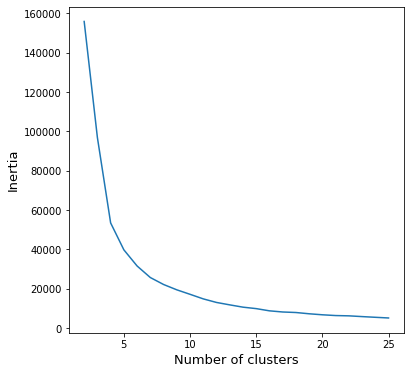

In [21]:
fig = plt.subplots(figsize=(6,6))

plt.plot(inertias.keys(), inertias.values())
plt.xlabel('Number of clusters', fontsize=13)
plt.ylabel('Inertia', fontsize=13)

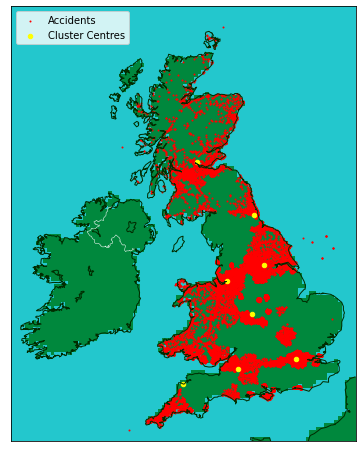

In [26]:
km = KMeans(n_clusters=8)
centers = km.fit(coords).cluster_centers_
centers = list(zip(*centers))


fig = plt.figure(figsize=(8, 8))
m = Basemap(llcrnrlon=-10.5,llcrnrlat=49.5,urcrnrlon=3.5,urcrnrlat=59.5,
            resolution='i',projection='tmerc',lon_0=-4.36,lat_0=54.7)
m.drawcoastlines(color='#012C00')
m.drawcountries(color='white')
m.drawlsmask(land_color='#00883D', ocean_color='#23C7CD',lakes=True)

m.scatter(accidents.longitude, accidents.latitude,
          latlon=True,
          alpha=1,
          s=1,
          color='red',
          marker='o',
          label='Accidents')

m.scatter(centers[0], centers[1],
          latlon=True,
          alpha=1,
          s=20,
          color='yellow',
          marker='o',
          label='Cluster Centres')

plt.legend(loc='upper left')

fig.savefig(plots_dir / 'accident_clusters')

## Clustering on weather conditions and speed limit

In [ ]:
accidents_vehicles = pd.merge(accidents, vehicles, on='accident_index')
avc = pd.merge(accidents_vehicles, casualties, on='accident_index')

avc.columns

In [ ]:
def clusterer(df, x_col, y_col, n_clusters=5):
    df = df.filter([x_col, y_col])
    
    km = KMeans(n_clusters = n_clusters)
    
    centers = list(zip(*km.fit(df).cluster_centers_))
    
    plt.subplots(figsize=(4, 4))
    
    plt.scatter(df[x_col], df[y_col], s=0.2)
    plt.scatter(centers[0], centers[1])
    plt.ylabel(y_col, fontsize=13)
    plt.xlabel(x_col, fontsize=13)
    plt.xticks(range(1, 10))
    
    plt.show()

In [ ]:
# clustering on age band of the driver and overturning
clusterer(avc, 'age_band_of_driver', 'skidding_and_overturning')

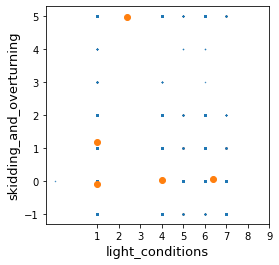

In [61]:
# clustering on light conditions and skidding and overturning
clusterer(avc, 'light_conditions', 'skidding_and_overturning')

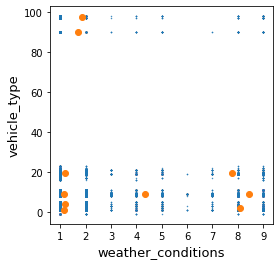

In [62]:
# clustering on weather conditions and vehicle type
clusterer(avc, 'weather_conditions', 'vehicle_type', 10)

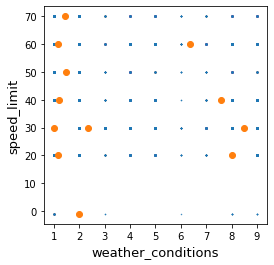

In [63]:
# clustering on weather conditions and speed limit
clusterer(avc, 'weather_conditions', 'speed_limit', 12)